## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
class ParameterHandle:
    def __init__(self, input_shape, output_units, num_neurons, activator, drop_ratio, regularizers,
                 batch_size, epochs):
        self.input_shape = input_shape
        self.output_units = output_units
        self.num_neurons = num_neurons
        self.activator = activator
        self.drop_ratio = drop_ratio
        self.regularizers = regularizers
        self.batch_size = batch_size
        self.epochs = epochs
        # self.optimizer = optimizer
        

In [6]:
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2

def build_mlp(params: ParameterHandle):
    
    input_layer = keras.layers.Input(params.input_shape)
    x = keras.layers.Dense(units=params.num_neurons[0], 
                           activation=None, 
                           name="hidden_layer_0",
                           kernel_regularizer=params.regularizers)(input_layer)
    x = Activation(params.activator)(x)
    x = BatchNormalization()(x)
    x = Dropout(params.drop_ratio)(x)
    
    for i, neurons in enumerate(params.num_neurons[1:]):
        x = keras.layers.Dense(units=neurons, 
                           activation=None, 
                           name="hidden_layer_{0}".format(str(i+1)),
                           kernel_regularizer=params.regularizers)(x)
        x = Activation(params.activator)(x)
        x = BatchNormalization()(x)
        x = Dropout(params.drop_ratio)(x)
    
    out = keras.layers.Dense(units=params.output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [7]:
optimizers = [
    keras.optimizers.SGD(lr=1e-3, momentum=0.95, decay=1e-5, nesterov=True),
    keras.optimizers.RMSprop(lr=1e-3, rho=0.95, epsilon=None, decay=1e-5),
    keras.optimizers.Adagrad(lr=1e-3, epsilon=None, decay=1e-5),
    keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
]

optimizers = [
    'SGD',
    'RMSprop',
    'Adagrad',
    'Adam'
]

handles = [
    ParameterHandle(x_train.shape[1:], 10, [256, 128, 64], 'relu', 0.1, l1_l2(1e-8,1e-8), 32, 50),
    ParameterHandle(x_train.shape[1:], 10, [256, 128, 64], 'relu', 0.2, l1_l2(1e-8,1e-8), 64, 50),
    ParameterHandle(x_train.shape[1:], 10, [256, 128, 64], 'relu', 0.1, l1_l2(1e-8,1e-8), 128, 50),
    ParameterHandle(x_train.shape[1:], 10, [256, 128, 64], 'relu', 0.2, l1_l2(1e-12,1e-12), 128, 50)
]

In [8]:
print(handles[0].num_neurons[1:])

[128, 64]


In [9]:
results = {}

for handle, optimizer in zip(handles, optimizers):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(handle)
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=handle.epochs, 
              batch_size=handle.batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-{0}".format(optimizer)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0720 15:20:05.865545  8000 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0720 15:20:05.866544  8000 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 15:20:05.868545  8000 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 15:20:05.869545  8000 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 15

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 256)               786688    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
__________

50000/50000 [==============================] - 14s 274us/step - loss: 1.3698 - acc: 0.5127 - val_loss: 1.3690 - val_acc: 0.5047
Epoch 44/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.3635 - acc: 0.5142 - val_loss: 1.4432 - val_acc: 0.4788
Epoch 45/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.3614 - acc: 0.5158 - val_loss: 1.4126 - val_acc: 0.4934
Epoch 46/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.3580 - acc: 0.5167 - val_loss: 1.4432 - val_acc: 0.4806
Epoch 47/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.3528 - acc: 0.5204 - val_loss: 1.3486 - val_acc: 0.5151
Epoch 48/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.3529 - acc: 0.5190 - val_loss: 1.3896 - val_acc: 0.4985
Epoch 49/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.3441 - acc: 0.5215 - val_loss: 1.3466 - val_acc: 0.5141
Epoch 50/50
50000/50000 [=======

Epoch 36/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4055 - acc: 0.5004 - val_loss: 2.0028 - val_acc: 0.3223
Epoch 37/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4031 - acc: 0.5030 - val_loss: 1.5122 - val_acc: 0.4572
Epoch 38/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.3986 - acc: 0.5045 - val_loss: 1.5187 - val_acc: 0.4585
Epoch 39/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.4018 - acc: 0.5002 - val_loss: 1.5532 - val_acc: 0.4437
Epoch 40/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.3990 - acc: 0.5053 - val_loss: 1.4692 - val_acc: 0.4717
Epoch 41/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.3975 - acc: 0.5063 - val_loss: 1.4058 - val_acc: 0.5007
Epoch 42/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.3963 - acc: 0.5075 - val_loss: 1.4839 - val_acc: 0.4691
Epoch 43/50
50000/50000 [==

50000/50000 [==============================] - 5s 93us/step - loss: 1.2265 - acc: 0.5610 - val_loss: 1.3722 - val_acc: 0.5118
Epoch 30/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.2256 - acc: 0.5629 - val_loss: 1.3369 - val_acc: 0.5269
Epoch 31/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.2136 - acc: 0.5654 - val_loss: 1.3484 - val_acc: 0.5208
Epoch 32/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.2114 - acc: 0.5673 - val_loss: 1.3382 - val_acc: 0.5219
Epoch 33/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.2046 - acc: 0.5701 - val_loss: 1.3481 - val_acc: 0.5192
Epoch 34/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.2052 - acc: 0.5693 - val_loss: 1.3470 - val_acc: 0.5228
Epoch 35/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.1961 - acc: 0.5753 - val_loss: 1.3443 - val_acc: 0.5220
Epoch 36/50
50000/50000 [=====================

50000/50000 [==============================] - 5s 101us/step - loss: 1.4293 - acc: 0.4893 - val_loss: 1.4278 - val_acc: 0.4790
Epoch 23/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.4229 - acc: 0.4952 - val_loss: 1.4326 - val_acc: 0.4932
Epoch 24/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.4219 - acc: 0.4945 - val_loss: 1.4557 - val_acc: 0.4779
Epoch 25/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.4144 - acc: 0.4959 - val_loss: 1.3837 - val_acc: 0.5011
Epoch 26/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.4154 - acc: 0.4952 - val_loss: 1.4087 - val_acc: 0.4932
Epoch 27/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.4067 - acc: 0.4990 - val_loss: 1.4002 - val_acc: 0.4976
Epoch 28/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.4059 - acc: 0.4990 - val_loss: 1.4229 - val_acc: 0.4938
Epoch 29/50
50000/50000 [==============

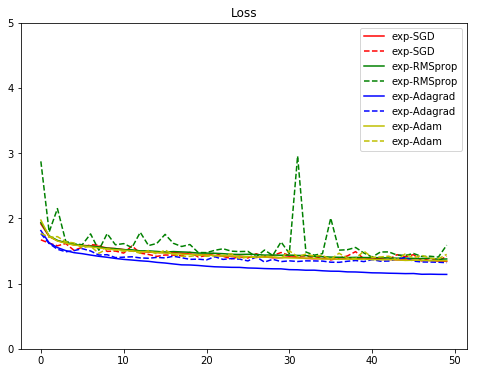

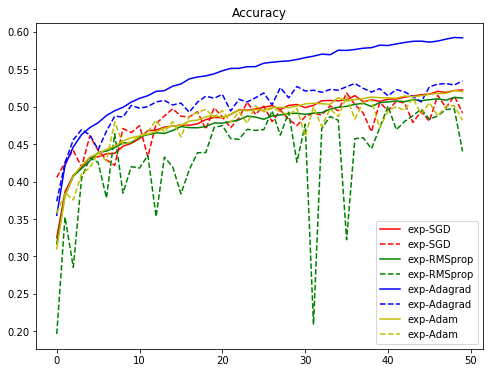

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()